**Import Libraries**

In [2]:
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
tf.compat.v1.enable_eager_execution()

**Read CSV File and Randomize**

In [3]:
abalone_dataframe = pd.read_csv("abalone.csv")
abalone_dataframe.dropna()#remove the empty data
abalone_dataframe = abalone_dataframe.reindex(np.random.permutation(abalone_dataframe.index))#reindex with randomly
abalone_dataframe

,sex,length,diameter,height,whole-weight,shucked-weight,viscera-weight,shell-weight,rings
203,F,0.530,0.435,0.170,0.8155,0.2985,0.1550,0.2750,13
229,F,0.530,0.415,0.160,0.7830,0.2935,0.1580,0.2450,15
3587,M,0.635,0.495,0.170,1.3695,0.6570,0.3055,0.3650,10
3108,I,0.375,0.285,0.080,0.2260,0.0975,0.0400,0.0725,7
607,I,0.485,0.370,0.130,0.4580,0.1810,0.1130,0.1360,10
...,...,...,...,...,...,...,...,...,...
3085,I,0.255,0.185,0.060,0.0925,0.0390,0.0210,0.0250,6
2152,F,0.400,0.300,0.115,0.3025,0.1335,0.0465,0.0935,8
1789,F,0.545,0.385,0.150,1.1185,0.5425,0.2445,0.2845,9
2201,F,0.645,0.490,0.215,1.4060,0.4265,0.2285,0.5100,25


**Create Training and Validation Data**

In [4]:
def preprocess_features(dataframe, selected_features):
    output_features = dataframe[selected_features]
    
    return output_features

In [5]:
#Single Panda Series
def preprocess_targets(dataframe, selected_target):
    output_targets = dataframe[selected_target]
    
    return output_targets

In [5]:
training_split = int(0.6 * len(abalone_dataframe))
validations_split = int(0.3 * len(abalone_dataframe))

selected_features = [
    "sex",
    "length",
    "diameter",
    "height",
    "rings"]

selected_target = "whole-weight"

#Feature Columns
sex_vocab_list = ["M", "F", "I"]

feature_columns = {
    tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("sex", sex_vocab_list)),#A CategoricalColumn with in-memory vocabulary.
    tf.feature_column.numeric_column("length"),
    tf.feature_column.numeric_column("diameter"),
    tf.feature_column.numeric_column("height"),
    tf.feature_column.numeric_column("rings")
}

#Panda Data
training_examples = preprocess_features(abalone_dataframe.iloc[0:training_split], selected_features)
training_targets = preprocess_targets(abalone_dataframe.iloc[0:training_split], selected_target)
validation_examples = preprocess_features(abalone_dataframe.iloc[training_split:training_split + validations_split], selected_features)
validation_targets = preprocess_targets(abalone_dataframe.iloc[training_split:training_split + validations_split], selected_target)
#Do not touch until end!
test_examples = preprocess_features(abalone_dataframe.iloc[training_split + validations_split:], selected_features)
test_targets = preprocess_targets(abalone_dataframe.iloc[training_split + validations_split:], selected_target)

**Training Functions**

In [7]:
#Return next batch (Of type of Tensorflow Dataset)
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), targets))
    
    if(shuffle):
        dataset = dataset.shuffle(1000)
    
    dataset = dataset.batch(batch_size).repeat(num_epochs)
    
    return dataset

In [8]:
def train_linear_regression_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
    
    #Initialize Linear Regressor
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=optimizer
    )
    
    #Training Functions
    training_input_fn = lambda: input_fn(
        training_examples,
        training_targets,
        batch_size=batch_size) 
    predict_training_input_fn = lambda: input_fn(
        training_examples, 
        training_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Validation Function
    predict_validation_input_fn = lambda: input_fn(
        validation_examples, 
        validation_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Train Model
    training_rmse = []
    validation_rmse = []
    
    print("Training Model")
    for period in range(0, periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            #Manually break total steps by 10
            steps=steps_per_period
        )
        
        #Use Sklearn to calculate RMSE
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        
        #Calculate Validation RMSE
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        #Append Losses
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
        print("Period:", period, "RMSE:", training_root_mean_squared_error)
    print("Training Finished")
    
    #Graph
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

In [9]:
def train_dnn_regression_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    hidden_units,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    ):

    periods = 10
    steps_per_period = steps / periods
    
    #Initialize DNN Regressor
    optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=feature_columns,
        hidden_units=hidden_units,
        optimizer=optimizer,
        activation_fn=tf.nn.leaky_relu
    )
    
    #Training Functions
    training_input_fn = lambda: input_fn(
        training_examples,
        training_targets,
        batch_size=batch_size) 
    predict_training_input_fn = lambda: input_fn(
        training_examples, 
        training_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Validation Function
    predict_validation_input_fn = lambda: input_fn(
        validation_examples, 
        validation_targets, 
        num_epochs=1, 
        shuffle=False)
    
    #Train Model
    training_rmse = []
    validation_rmse = []
    
    print("Training Model")
    for period in range(0, periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            #Manually break total steps by 10
            steps=steps_per_period
        )
        
        #Use Sklearn to calculate RMSE
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        
        #Calculate Validation RMSE
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        #Append Losses
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
        print("Period:", period, "RMSE:", training_root_mean_squared_error)
    print("Training Finished")
    
    #Graph
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return dnn_regressor

**Training**

W0707 21:35:02.781367 139684101514880 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0707 21:35:02.782592 139684101514880 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpdlfqohtv
W0707 21:35:02.791587 139684101514880 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Training Model


W0707 21:35:03.190185 139684101514880 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2655: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0707 21:35:03.206148 139684101514880 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4207: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0707 21:35:03.207670 139684101514880 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4262: VocabularyListCategoricalColumn._num_

Period: 0 RMSE: 0.39576406672508396


W0707 21:35:07.250020 139684101514880 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


Period: 1 RMSE: 0.37930160644876243
Period: 2 RMSE: 0.3651355533315346
Period: 3 RMSE: 0.3576380254239989


W0707 21:35:20.355999 139684101514880 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Period: 4 RMSE: 0.3521646442344942
Period: 5 RMSE: 0.3496996010691135
Period: 6 RMSE: 0.34231388156029185
Period: 7 RMSE: 0.34685154505823584
Period: 8 RMSE: 0.3387508713379817
Period: 9 RMSE: 0.33140041212526405
Training Finished


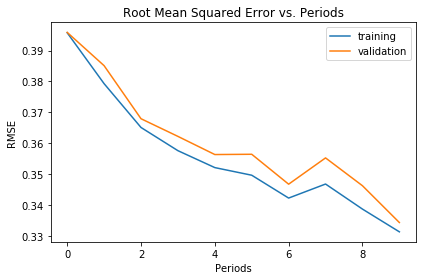

In [10]:
linear_regressor = train_linear_regression_model(
    learning_rate=0.001,
    steps=1000,
    batch_size=20,
    feature_columns = feature_columns,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

W0707 21:35:41.903113 139684101514880 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpsu3dntzy


Training Model
Period: 0 RMSE: 0.3346758924892736
Period: 1 RMSE: 0.32917577788756597
Period: 2 RMSE: 0.31924418805629334
Period: 3 RMSE: 0.3715144872207029
Period: 4 RMSE: 0.3142861649549405
Period: 5 RMSE: 0.309832671969487
Period: 6 RMSE: 0.30853138207341624
Period: 7 RMSE: 0.303816855674453
Period: 8 RMSE: 0.3032922086936399
Period: 9 RMSE: 0.29949448611027746
Training Finished


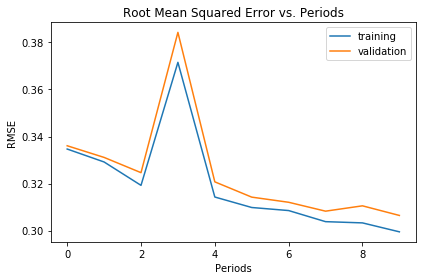

In [11]:
dnn_regressor = train_dnn_regression_model(
    learning_rate=0.001,
    regularization_strength=0.1,
    steps=1000,
    batch_size=20,
    hidden_units=[2, 1],
    feature_columns=feature_columns,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

**Test Data**

In [12]:
def test_regression_model(model, test_examples, test_targets):
    predict_test_input_fn = lambda: input_fn(
        test_examples, 
        test_targets, 
        num_epochs=1, 
        shuffle=False)
    
    test_predictions = model.predict(input_fn=predict_test_input_fn)
    test_predictions = np.array([item['predictions'][0] for item in test_predictions])

    for prediction, label in zip(test_predictions, test_targets): 
        print("Prediction:", prediction, "Label:", label, "Diff:", abs(prediction - label))
    
    return test_predictions

In [17]:
#Linear Regressor
test_predictions_linear_regressor = test_regression_model(linear_regressor, test_examples, test_targets)
test_rmse_linear_regressor = math.sqrt(metrics.mean_squared_error(test_predictions_linear_regressor, test_targets))
print("Test RMSE:", test_rmse_linear_regressor)

Prediction: 1.3803372 Label: 0.991 Diff: 0.3893372383117676
Prediction: 1.5040704 Label: 0.8685 Diff: 0.6355704011917114
Prediction: 0.75808877 Label: 0.271 Diff: 0.4870887675285339
Prediction: 1.2689596 Label: 1.5219999999999998 Diff: 0.2530403585433958
Prediction: 0.5820755 Label: 0.7005 Diff: 0.11842452335357667
Prediction: 0.54593873 Label: 0.599 Diff: 0.05306126976013181
Prediction: 1.0698929 Label: 1.159 Diff: 0.08910711669921878
Prediction: 1.225894 Label: 2.3235 Diff: 1.097606025695801
Prediction: 1.1375406 Label: 1.1355 Diff: 0.002040578842163132
Prediction: 1.011941 Label: 0.927 Diff: 0.08494095611572261
Prediction: 0.6807859 Label: 0.795 Diff: 0.11421410560607914
Prediction: 1.0527419 Label: 1.056 Diff: 0.0032581148147583505
Prediction: 1.024384 Label: 1.2255 Diff: 0.20111597824096683
Prediction: 0.558823 Label: 1.0835 Diff: 0.5246770105361938
Prediction: 1.246988 Label: 1.2415 Diff: 0.005488058090209913
Prediction: 0.95237184 Label: 0.782 Diff: 0.17037183570861814
Predictio

In [19]:
#DNN Regressor
test_predictions_dnn_regressor = test_regression_model(dnn_regressor, test_examples, test_targets)
test_rmse_dnn_regressor = math.sqrt(metrics.mean_squared_error(test_predictions_dnn_regressor, test_targets))
print("Test RMSE:", test_rmse_dnn_regressor)

Prediction: 0.14335607 Label: 0.991 Diff: 0.8476439300775528
Prediction: 0.16796345 Label: 0.8685 Diff: 0.7005365548133851
Prediction: 0.050864346 Label: 0.271 Diff: 0.22013565367460253
Prediction: 0.09721635 Label: 1.5219999999999998 Diff: 1.4247836471796034
Prediction: 0.0644235 Label: 0.7005 Diff: 0.6360764985084534
Prediction: 0.064844124 Label: 0.599 Diff: 0.534155875980854
Prediction: 0.06591567 Label: 1.159 Diff: 1.0930843334794045
Prediction: 0.07143818 Label: 2.3235 Diff: 2.2520618215799333
Prediction: 0.08003644 Label: 1.1355 Diff: 1.0554635609984397
Prediction: 0.06657183 Label: 0.927 Diff: 0.860428168296814
Prediction: 0.07988396 Label: 0.795 Diff: 0.7151160371303559
Prediction: 0.06616056 Label: 1.056 Diff: 0.9898394403457642
Prediction: 0.064849615 Label: 1.2255 Diff: 1.1606503849029541
Prediction: 0.06440987 Label: 1.0835 Diff: 1.0190901330709456
Prediction: 0.1039357 Label: 1.2415 Diff: 1.1375642963647843
Prediction: 0.058677297 Label: 0.782 Diff: 0.7233227029144764
Pre

Prediction: 0.10483014 Label: 1.5785 Diff: 1.4736698616147041
Prediction: 0.073465504 Label: 0.6025 Diff: 0.5290344962477684
Prediction: 0.14215618 Label: 2.13 Diff: 1.9878438162803649
Prediction: 0.065158784 Label: 0.8265 Diff: 0.7613412156105042
Prediction: 0.07578728 Label: 0.3635 Diff: 0.2877127165198326
Prediction: 0.06559033 Label: 1.3645 Diff: 1.2989096705317498
Prediction: 0.05066345 Label: 0.139 Diff: 0.08833655112981798
Prediction: 0.06519556 Label: 0.48700000000000004 Diff: 0.4218044395446778
Prediction: 0.074591756 Label: 1.224 Diff: 1.1494082441329956
Prediction: 0.08041057 Label: 0.9309999999999999 Diff: 0.8505894300937652
Prediction: 0.08129603 Label: 0.3625 Diff: 0.28120397329330443
Prediction: 0.08710936 Label: 2.21 Diff: 2.1228906428813934
Prediction: 0.104209535 Label: 0.995 Diff: 0.8907904651761055
Prediction: 0.1055174 Label: 1.2515 Diff: 1.1459825977087021
Prediction: 0.049447156 Label: 0.7959999999999999 Diff: 0.7465528435111045
Prediction: 0.09580867 Label: 1.26

**Additional Info**

In [20]:
#Linear Regressor Weights
for v in linear_regressor.get_variable_names():
    print(v, linear_regressor.get_variable_value(v))

global_step 2000
linear/linear_model/bias_weights [-0.01088332]
linear/linear_model/diameter/weights [[0.45847854]]
linear/linear_model/height/weights [[0.15812753]]
linear/linear_model/length/weights [[0.5658972]]
linear/linear_model/rings/weights [[0.03753022]]
linear/linear_model/sex_indicator/weights [[ 0.10234195]
 [ 0.12504208]
 [-0.23826763]]


In [22]:
#DNN Regressor Weights
#for v in dnn_regressor.get_variable_names():
#    print(v, "\n", dnn_regressor.get_variable_value(v))